In [1]:
rm(list = ls())

In [2]:
library(LalRUtils)
libreq(data.table, magrittr, tidyverse, janitor, huxtable, knitr, patchwork, timeDate, plotly)
# theme_set(lal_plot_theme(textangle = 90))
theme_set(lal_plot_theme(textangle = 90))
set.seed(42)
options(repr.plot.width = 15, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "magrittr"   TRUE  
 [3,] "tidyverse"  TRUE  
 [4,] "janitor"    TRUE  
 [5,] "huxtable"   TRUE  
 [6,] "knitr"      TRUE  
 [7,] "patchwork"  TRUE  
 [8,] "timeDate"   TRUE  
 [9,] "plotly"     TRUE  


# Mobility Reports Query
[info](https://console.cloud.google.com/marketplace/details/bigquery-public-datasets/covid19_google_mobility?filter=solution-type%3Adataset&id=db650d71-e53e-4677-b37b-d8bdca3ec4dc&project=spatial-acumen-244921&folder&organizationId)

In [3]:
libreq(tidyverse, DBI, dbplyr, RSQLite, bigrquery, tictoc)

     wants       loaded
[1,] "tidyverse" TRUE  
[2,] "DBI"       TRUE  
[3,] "dbplyr"    TRUE  
[4,] "RSQLite"   TRUE  
[5,] "bigrquery" TRUE  
[6,] "tictoc"    TRUE  


In [4]:
projid <- Sys.getenv("GCE_DEFAULT_PROJECT_ID")
bq_auth(email = "lal.apoorva@gmail.com",
       path = "~/keys/sandbox.json")

In [5]:
bq_con <-  dbConnect(
    bigrquery::bigquery(),
    project = "bigquery-public-data",
    dataset = "covid19_google_mobility",
    billing = projid
    )
bq_con
dbListTables(bq_con)

<BigQueryConnection>
  Dataset: bigquery-public-data.covid19_google_mobility
  Billing: spatial-acumen-244921

[1] "mobility_report"

In [6]:
mob <- tbl(bq_con, "mobility_report")
mob %>% glimpse

Rows: ??
Columns: 11
Database: BigQueryConnection
$ country_region_code                                <chr> "AE", "AE", "AE", …
$ country_region                                     <chr> "United Arab Emira…
$ sub_region_1                                       <chr> NA, NA, NA, NA, NA…
$ sub_region_2                                       <chr> NA, NA, NA, NA, NA…
$ date                                               <date> 2020-04-05, 2020-…
$ retail_and_recreation_percent_change_from_baseline <int> -61, -63, -63, -63…
$ grocery_and_pharmacy_percent_change_from_baseline  <int> -30, -32, -30, -30…
$ parks_percent_change_from_baseline                 <int> -58, -58, -73, -74…
$ transit_stations_percent_change_from_baseline      <int> -79, -78, -78, -78…
$ workplaces_percent_change_from_baseline            <int> -57, -56, -55, -55…
$ residential_percent_change_from_baseline           <int> 31, 30, 30, 30, 33…


In [7]:
tic()
mob %>% collect() ->
    mobility_df
toc()

37.672 sec elapsed


In [8]:
mobility_df %<>% setDT
mobility_df %>% glimpse()

Rows: 458,565
Columns: 11
$ country_region_code                                <chr> "AE", "AE", "AE", …
$ country_region                                     <chr> "United Arab Emira…
$ sub_region_1                                       <chr> NA, NA, NA, NA, NA…
$ sub_region_2                                       <chr> NA, NA, NA, NA, NA…
$ date                                               <date> 2020-04-05, 2020-…
$ retail_and_recreation_percent_change_from_baseline <int> -61, -63, -63, -63…
$ grocery_and_pharmacy_percent_change_from_baseline  <int> -30, -32, -30, -30…
$ parks_percent_change_from_baseline                 <int> -58, -58, -73, -74…
$ transit_stations_percent_change_from_baseline      <int> -79, -78, -78, -78…
$ workplaces_percent_change_from_baseline            <int> -57, -56, -55, -55…
$ residential_percent_change_from_baseline           <int> 31, 30, 30, 30, 33…


In [9]:
fwrite(mobility_df, "data/google-mobility-reports.csv")
dbDisconnect(bq_con)

## Viz

In [10]:
mobility_df = fread("data/google-mobility-reports.csv")
old = c('retail_and_recreation_percent_change_from_baseline',
  'grocery_and_pharmacy_percent_change_from_baseline',
  'parks_percent_change_from_baseline',
  'transit_stations_percent_change_from_baseline',
  'workplaces_percent_change_from_baseline',
  'residential_percent_change_from_baseline')
new = c("retail", "grocery", "parks", "transit", "work", "home")
setnames(mobility_df, old, new)
mobility_df[, d := lubridate::ymd(date)]
mobility_df[, weekend := isWeekend(d)]
mobility_df %>% glimpse

Rows: 458,565
Columns: 13
$ country_region_code <chr> "AE", "AE", "AE", "AE", "AE", "AE", "AE", "AE", "…
$ country_region      <chr> "United Arab Emirates", "United Arab Emirates", "…
$ sub_region_1        <chr> "", "", "", "", "", "", "", "", "", "", "", "", "…
$ sub_region_2        <chr> "", "", "", "", "", "", "", "", "", "", "", "", "…
$ date                <chr> "2020-04-05", "2020-04-06", "2020-04-07", "2020-0…
$ retail              <int> -61, -63, -63, -63, -64, -60, -62, -62, -63, -63,…
$ grocery             <int> -30, -32, -30, -30, -31, -28, -30, -31, -32, -32,…
$ parks               <int> -58, -58, -73, -74, -76, -74, -73, -74, -74, -74,…
$ transit             <int> -79, -78, -78, -78, -79, -79, -78, -78, -78, -79,…
$ work                <int> -57, -56, -55, -55, -55, -55, -55, -55, -56, -55,…
$ home                <int> 31, 30, 30, 30, 33, 30, 30, 30, 31, 34, 30, 30, 3…
$ d                   <date> 2020-04-05, 2020-04-06, 2020-04-07, 2020-04-08, …
$ weekend             <lgl

### US Counties

In [11]:
us_mob = mobility_df[country_region_code == "US"]
us_mob %>% head

country_region_code country_region sub_region_1 sub_region_2      date      
1 US                  United States  Alabama      Dallas County     2020-02-26
2 US                  United States  Alabama      Dallas County     2020-03-12
3 US                  United States  Alabama      DeKalb County     2020-02-29
4 US                  United States  Alabama      DeKalb County     2020-03-07
5 US                  United States  Alabama      Lauderdale County 2020-03-07
6 US                  United States  Alabama      Montgomery County 2020-02-29
  retail grocery parks transit work home d          weekend
1 31      5      NA    NA       3   -4   2020-02-26 FALSE  
2 21     10      NA    NA       0   -4   2020-03-12 FALSE  
3 18      8      NA    NA       7   -4   2020-02-29  TRUE  
4 17      4      NA    NA      10   -4   2020-03-07  TRUE  
5 14      6      NA    NA       4   -4   2020-03-07  TRUE  
6 18     10      88    16       7   -4   2020-02-29  TRUE

In [12]:
bay   = paste0(c( "San Francisco", "San Mateo", "Santa Clara",
                        "Alameda", "Contra Costa", "Marin"), " County")

socal = paste0(c("Los Angeles", "Orange", "San Bernardino", "Riverside", "Ventura", "Merced"),
               " County")

bay_area = us_mob[sub_region_1 == "California" & sub_region_2 %in% bay ]

la_area = us_mob[sub_region_1 == "California" & sub_region_2 %in% socal ]

# long
bay_area2 = melt(bay_area, id.vars = c("sub_region_2", "d", "weekend"),
        measure = c("retail", "grocery", "parks", "transit", "work", "home"),
        variable.name = "category")
la_area2 = melt(la_area, id.vars = c("sub_region_2", "d", "weekend"),
        measure = c("retail", "grocery", "parks", "transit", "work", "home"),
        variable.name = "category")

bay_area2 %>% head

sub_region_2   d          weekend category value
1 Alameda County 2020-03-24 FALSE   retail   -51  
2 Alameda County 2020-03-25 FALSE   retail   -49  
3 Alameda County 2020-03-26 FALSE   retail   -49  
4 Alameda County 2020-03-27 FALSE   retail   -52  
5 Alameda County 2020-04-02 FALSE   retail   -49  
6 Alameda County 2020-04-03 FALSE   retail   -51

In [13]:
mobility_faceted = function(df, cmap = T, leg = T, wknd = T){
    p =  ggplot(df, aes(x = d, y = value, group = category, colour = category))
    if (wknd == T){
        p = p + geom_vline(data = df[weekend == T],
                     mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1)
    }
    p = p + geom_point(size = 1, alpha = 0.5) + geom_smooth(se = F, size = 0.8) +
            geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
            scale_x_date(date_breaks = "1 week", date_labels = "%b %d") +
            facet_wrap(~ sub_region_2, scale = "free")
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}


mobility_plotter = function(df, col, cmap = T, leg = F){
    p = df %>%
        ggplot(aes(x = d, y = {{ col }}, group = sub_region_2, colour = sub_region_2)) +
            geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
            geom_vline(data = df[weekend == T],
                     mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1) +
            geom_point() + geom_smooth(se = F) +
            scale_x_date(date_breaks = "1 week", date_labels = "%b %d")
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



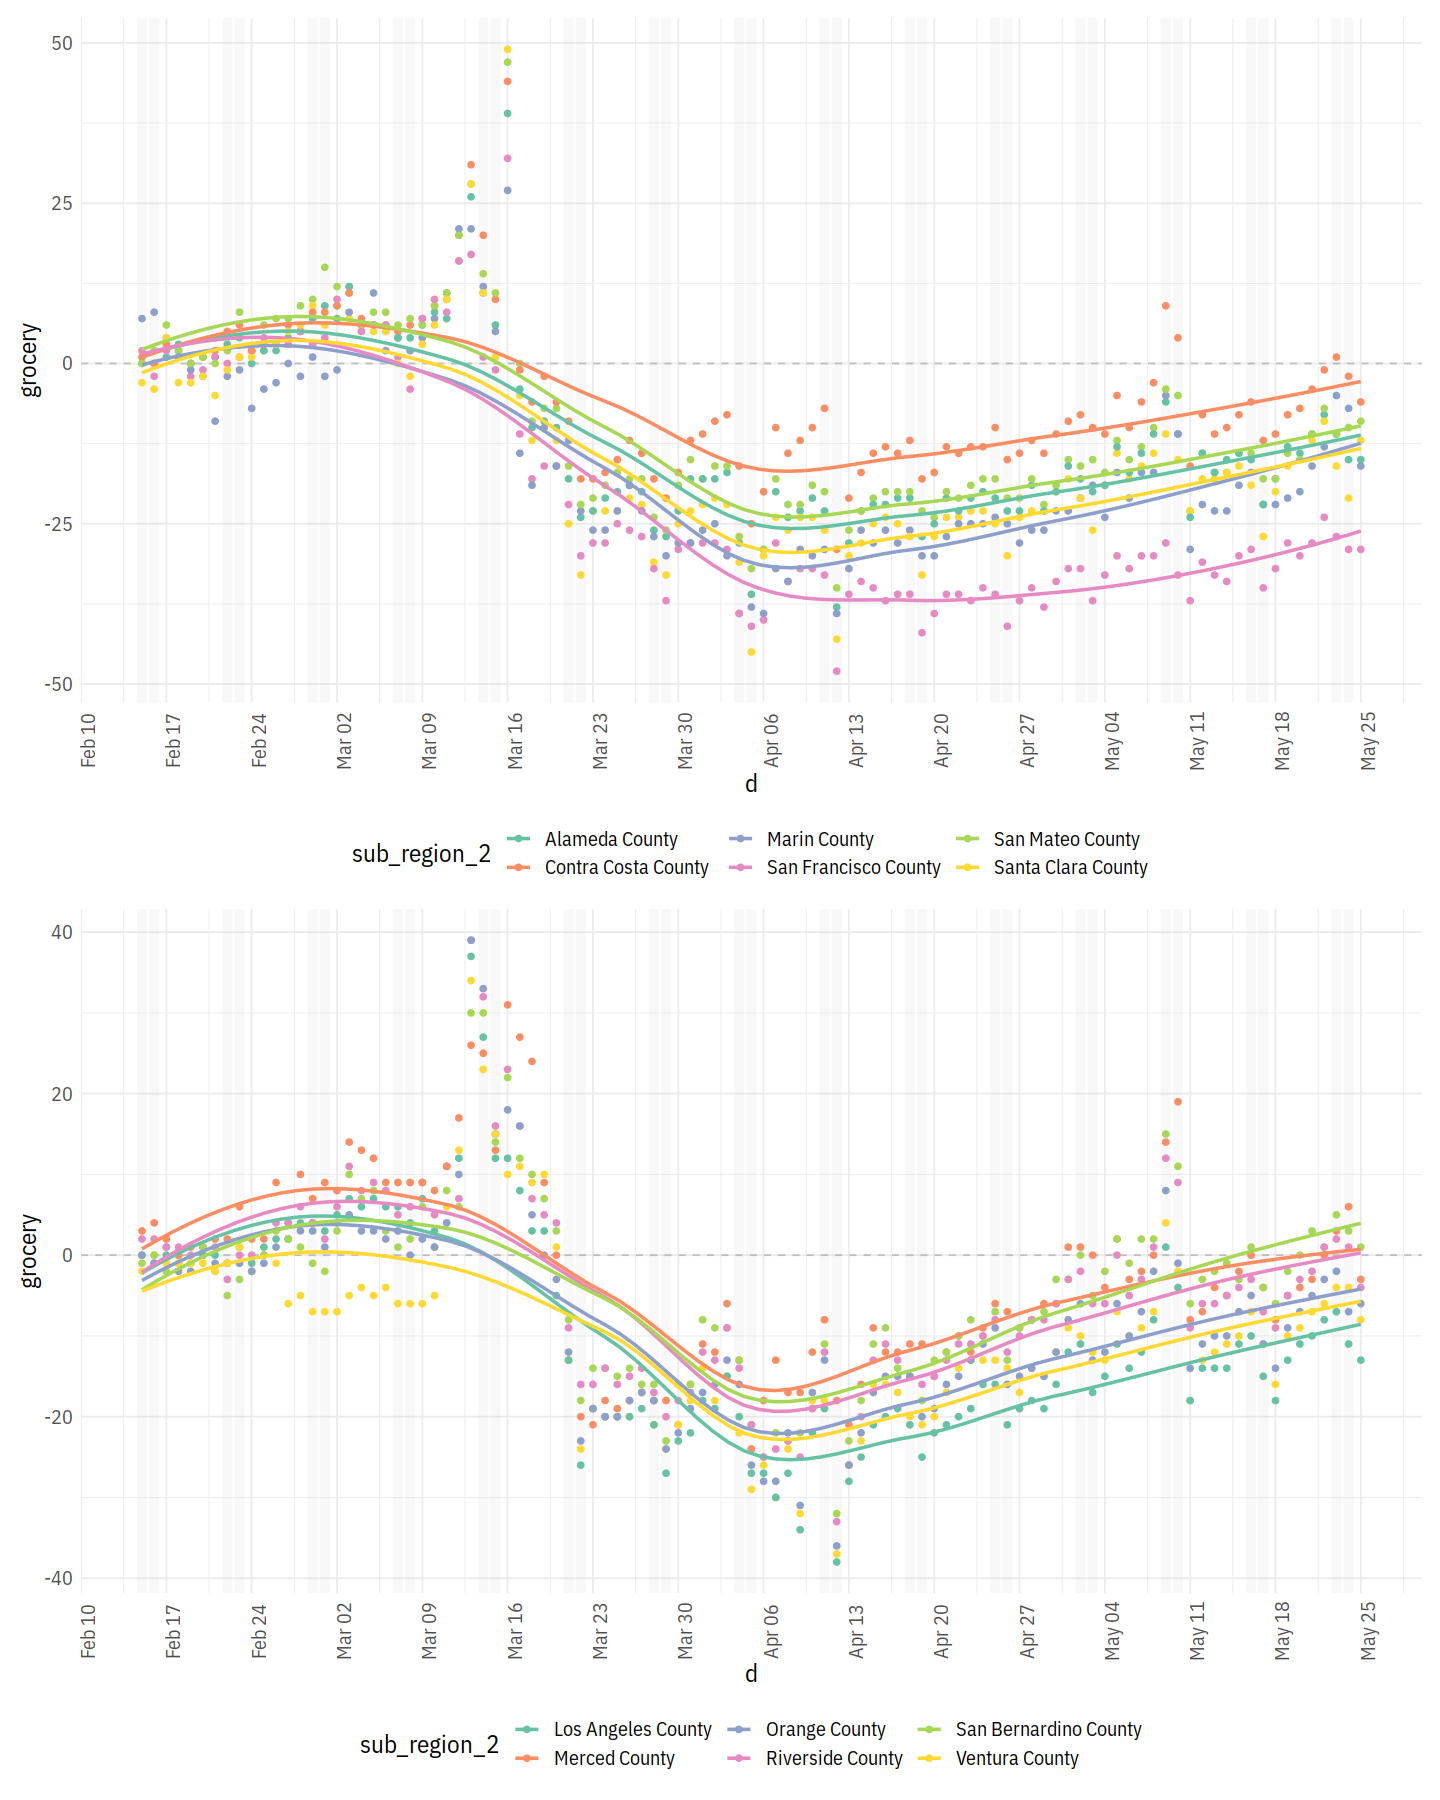

In [14]:
options(repr.plot.width = 12, repr.plot.height=15)
mobility_plotter(bay_area, grocery, leg = T) / mobility_plotter(la_area, grocery, leg = T)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



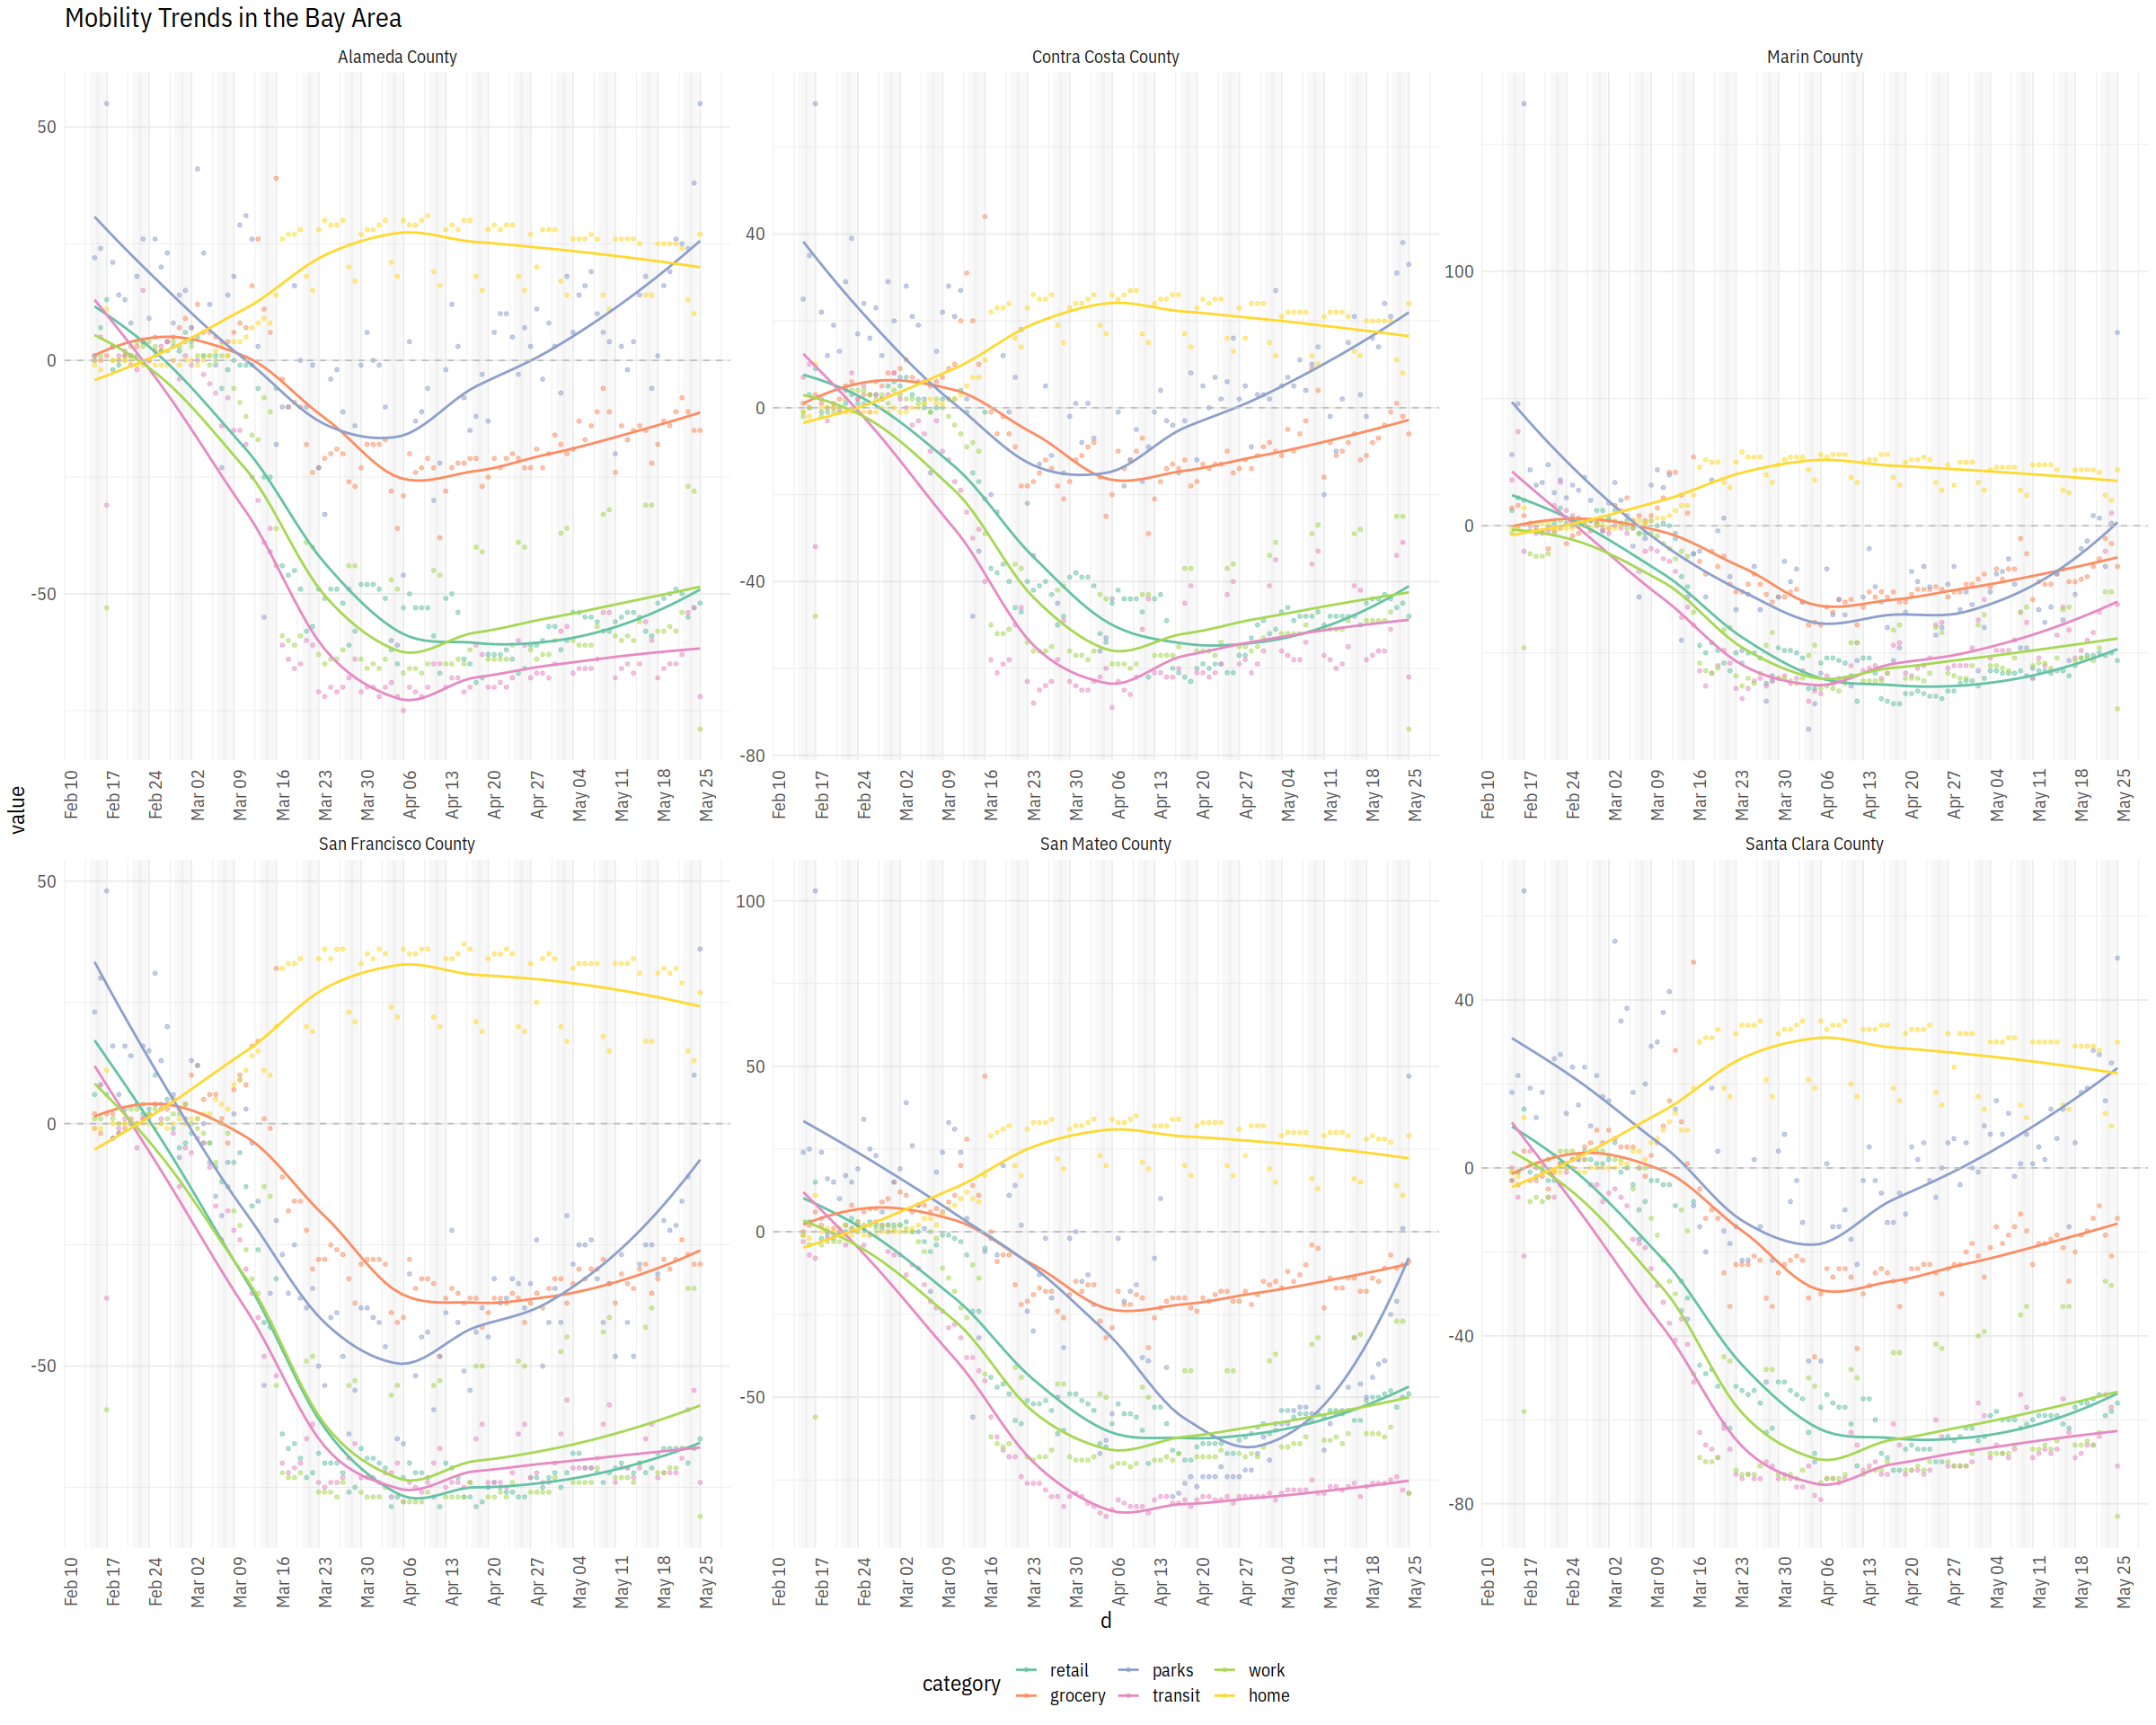

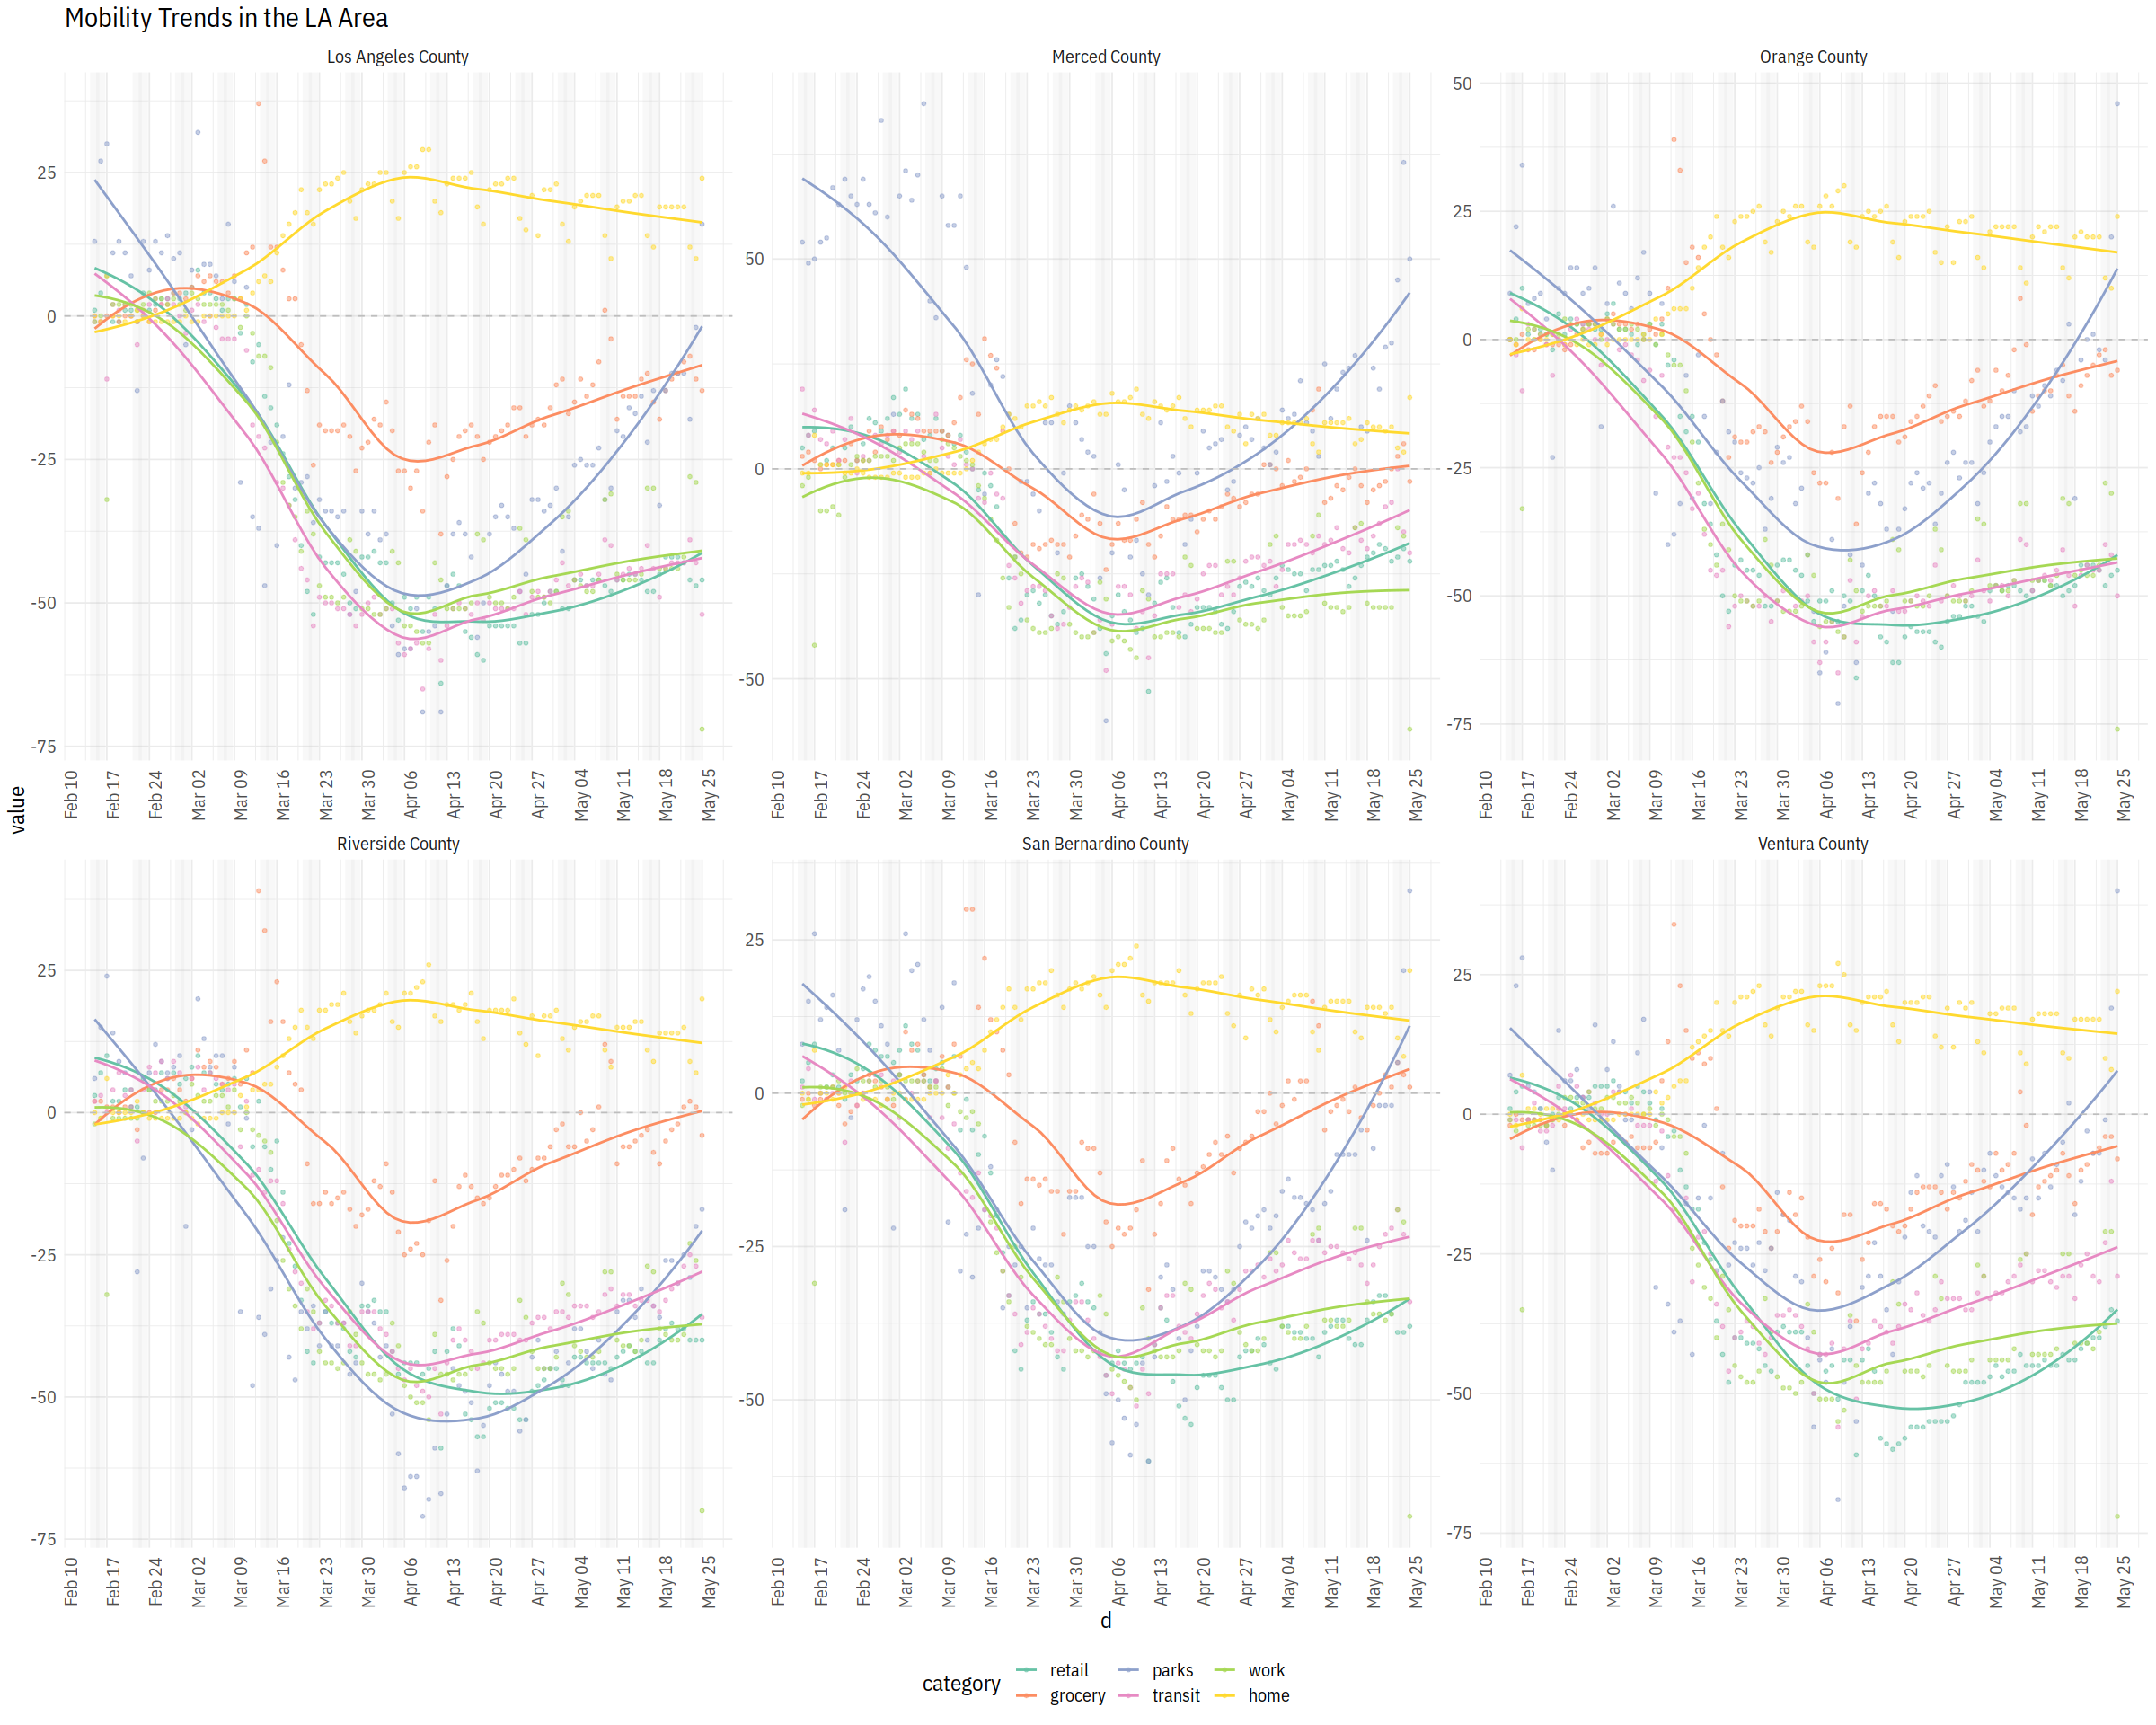

In [15]:
options(repr.plot.width = 20, repr.plot.height=16)
mobility_faceted(bay_area2) + ggtitle("Mobility Trends in the Bay Area")
mobility_faceted(la_area2)  + ggtitle("Mobility Trends in the LA Area")

## International

In [16]:
melter = function(df, keys = c("country_region", "d", "weekend")){
    df_long = melt(df, id.vars = keys,
        measure = c("retail", "grocery", "parks", "transit", "work", "home"),
        variable.name = "category")
    return(df_long)
}

subregion_faceted = function(df, cmap = T, freescale = F, leg = T, wknd = T){
    p = ggplot(df, aes(x = d, y = value, group = category, colour = category))
    if (wknd == T){
        p = p + geom_vline(data = df[weekend == T], mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1)
    }
    p = p +
        geom_point(size = 1, alpha = 0.5) + geom_smooth(se = F, size = 0.6) +
        geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
        scale_x_date(date_breaks = "1 week", date_labels = "%m-%d")
    if (freescale == T) {
        p = p + facet_wrap(~ sub_region_1, scale = "free_y")
    } else{
        p = p + facet_wrap(~ sub_region_1)
    }
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

country_faceted = function(df, freescale = F,  cmap = F, leg = F, wknd = T){
    p = ggplot(df, aes(x = d, y = value))
    if (wknd == T){
        p = p + geom_vline(data = df[weekend == T], mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1)
    }
    p = p +
        geom_point(size = 1, alpha = 0.5) + geom_smooth(se = F, size = 0.6) +
        geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
        scale_x_date(date_breaks = "1 week", date_labels = "%m-%d")
    if (freescale == T) {
        p = p + facet_wrap(~ category, scale = "free")
    } else{
        p = p + facet_wrap(~ category)
    }
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

mob_plotter = function(df, col, grp, leg = T){
    p = df %>%
        ggplot(aes(x = d, y = {{ col }}, group = {{grp}}, colour = {{grp}})) +
            geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
            geom_vline(data = df[weekend == T],
                     mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.3) +
        geom_point() + geom_smooth(se = F) +
        scale_x_date(date_breaks = "1 week", date_labels = "%m-%d")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



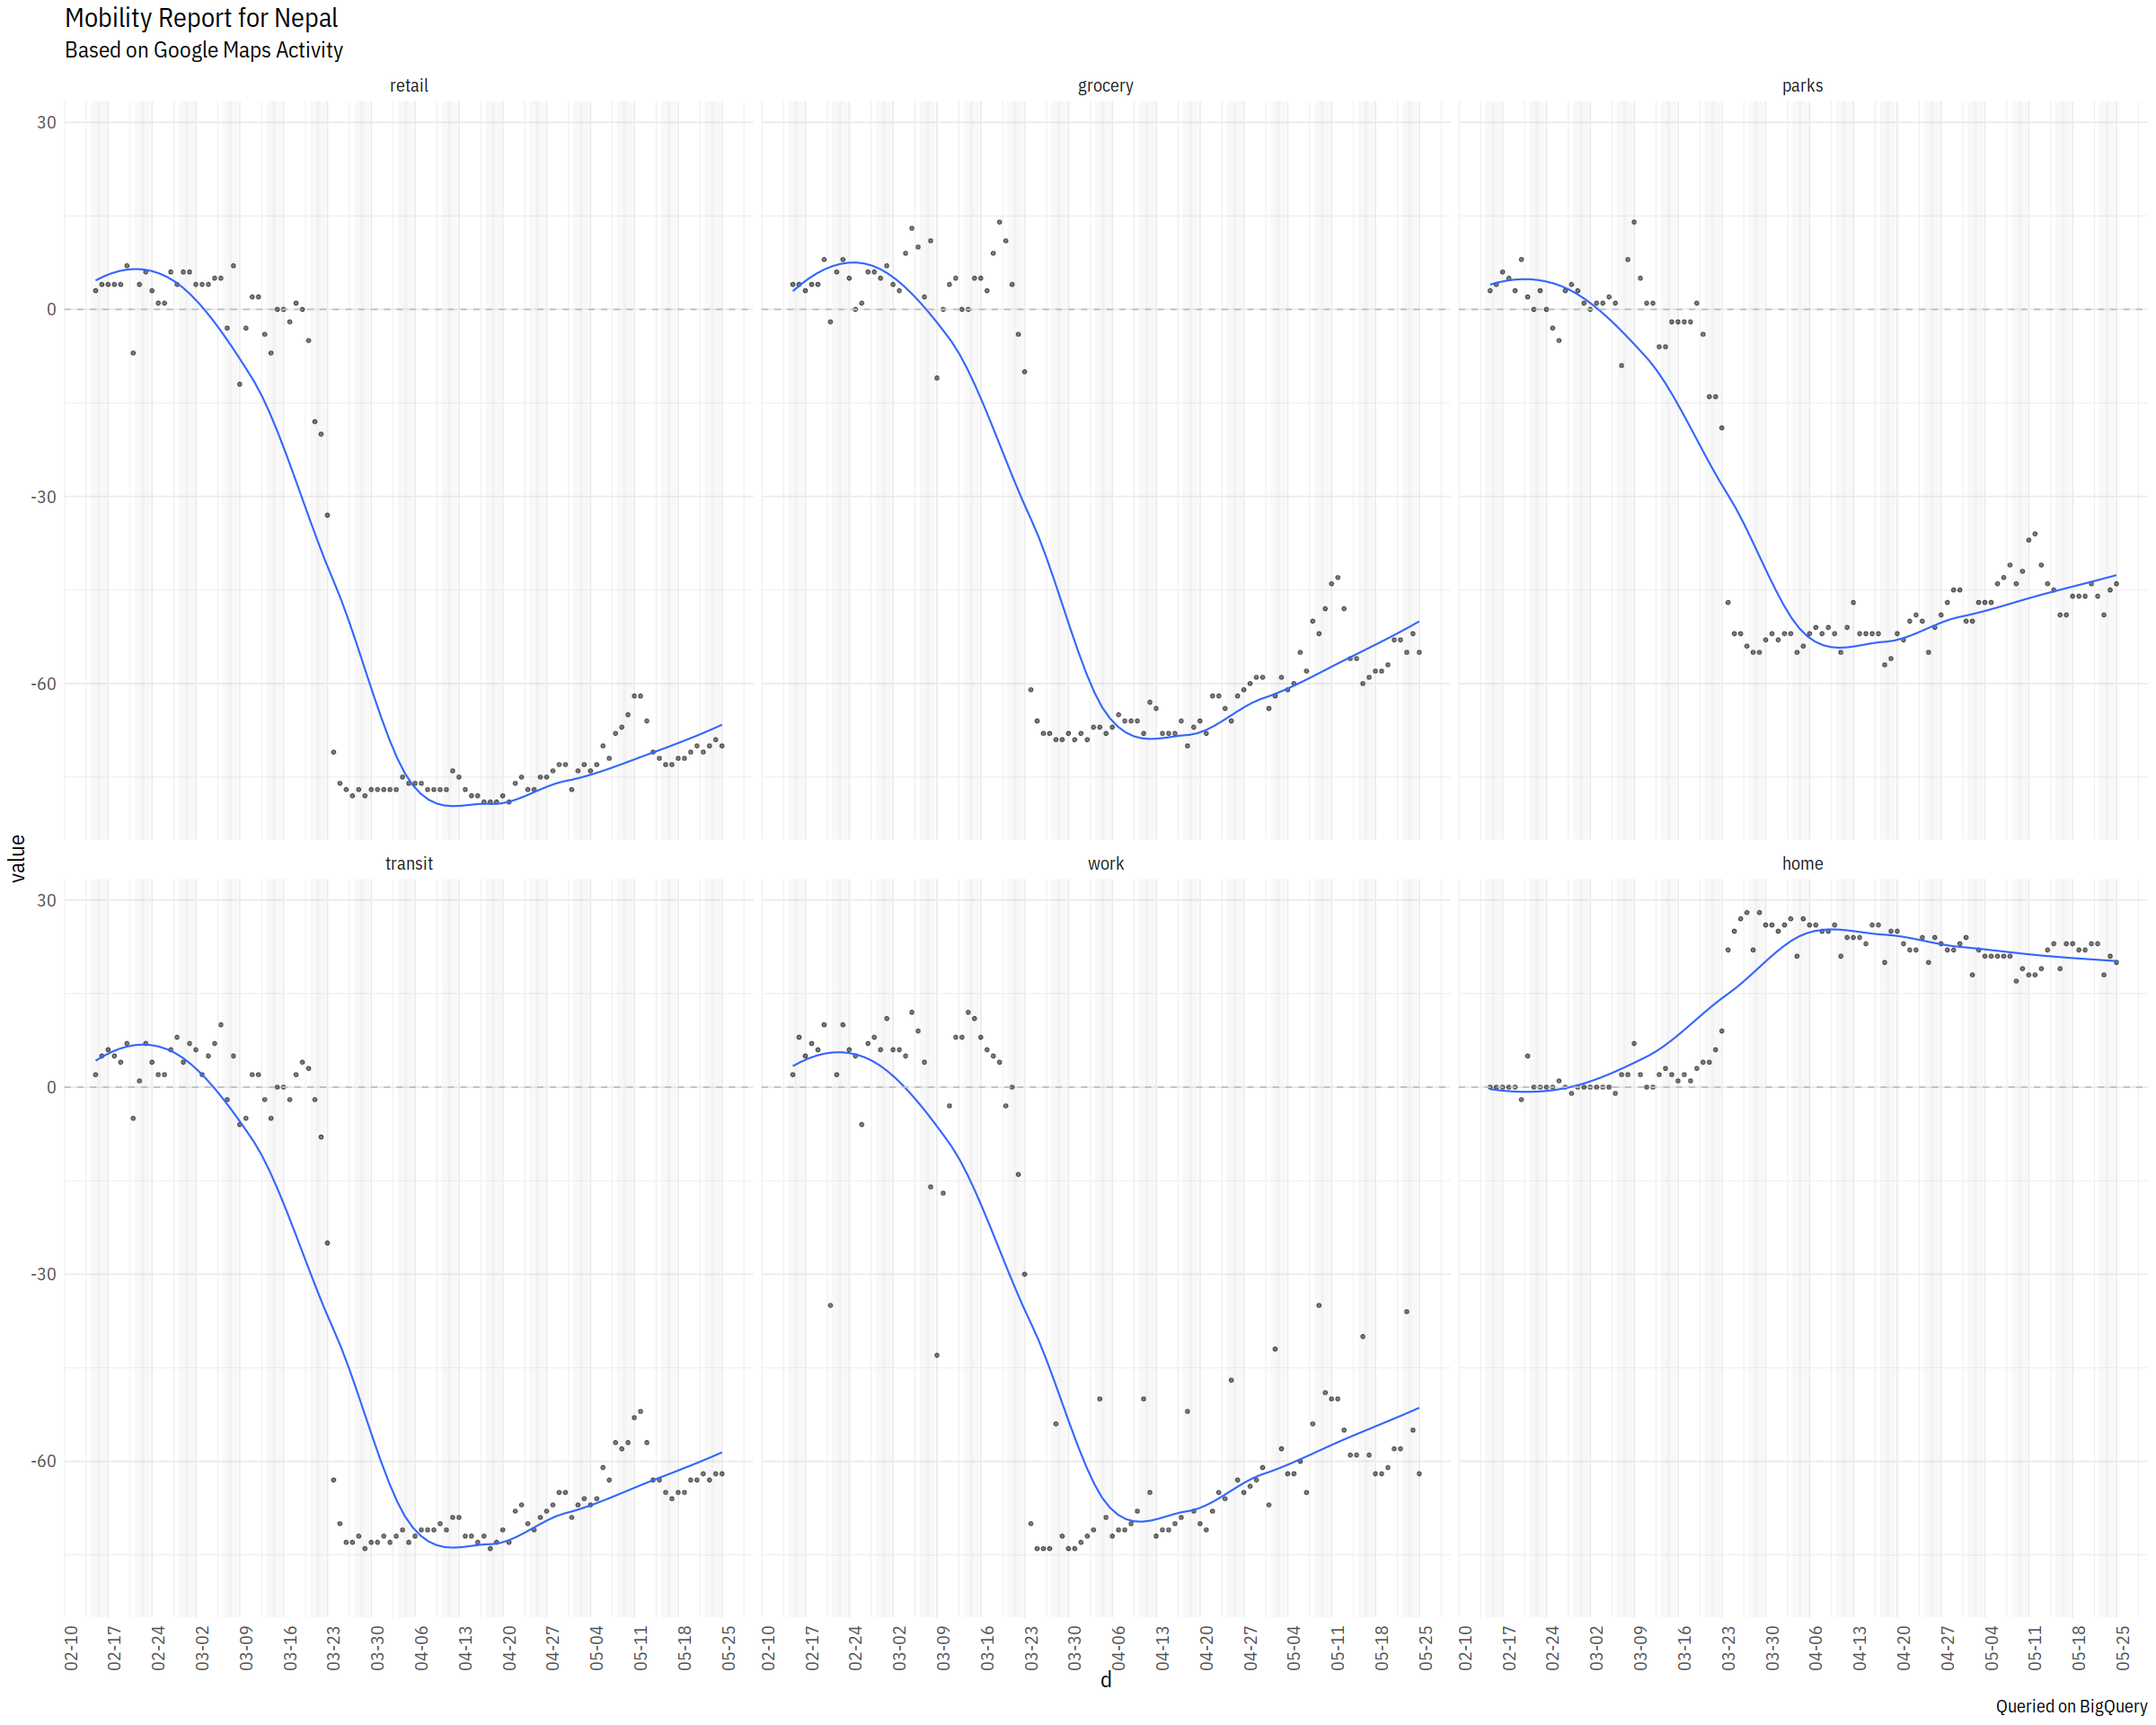

In [17]:
nep = mobility_df[country_region =="Nepal"]
nep_l = melter(nep)
(nep = country_faceted(nep_l) +
    labs(title = "Mobility Report for Nepal", subtitle = "Based on Google Maps Activity", caption = "Queried on BigQuery"))

In [52]:
ggsave("nep_mobility.jpg", nep, width = 20, height = 15)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



country_region_code country_region sub_region_1 sub_region_2 date      
1 IN                  India                                    2020-03-25
2 IN                  India                                    2020-03-26
3 IN                  India                                    2020-03-27
4 IN                  India                                    2020-03-28
5 IN                  India                                    2020-03-30
6 IN                  India                                    2020-03-31
  retail grocery parks transit work home d          weekend
1 -77    -64     -53   -73     -72  30   2020-03-25 FALSE  
2 -76    -64     -51   -73     -70  30   2020-03-26 FALSE  
3 -77    -64     -52   -73     -70  31   2020-03-27 FALSE  
4 -78    -65     -54   -73     -66  29   2020-03-28  TRUE  
5 -76    -63     -51   -74     -68  30   2020-03-30 FALSE  
6 -75    -63     -50   -73     -68  29   2020-03-31 FALSE

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 563 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 563 rows containing missing values (geom_point).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 563 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 563 rows containing missing values (geom_point).”


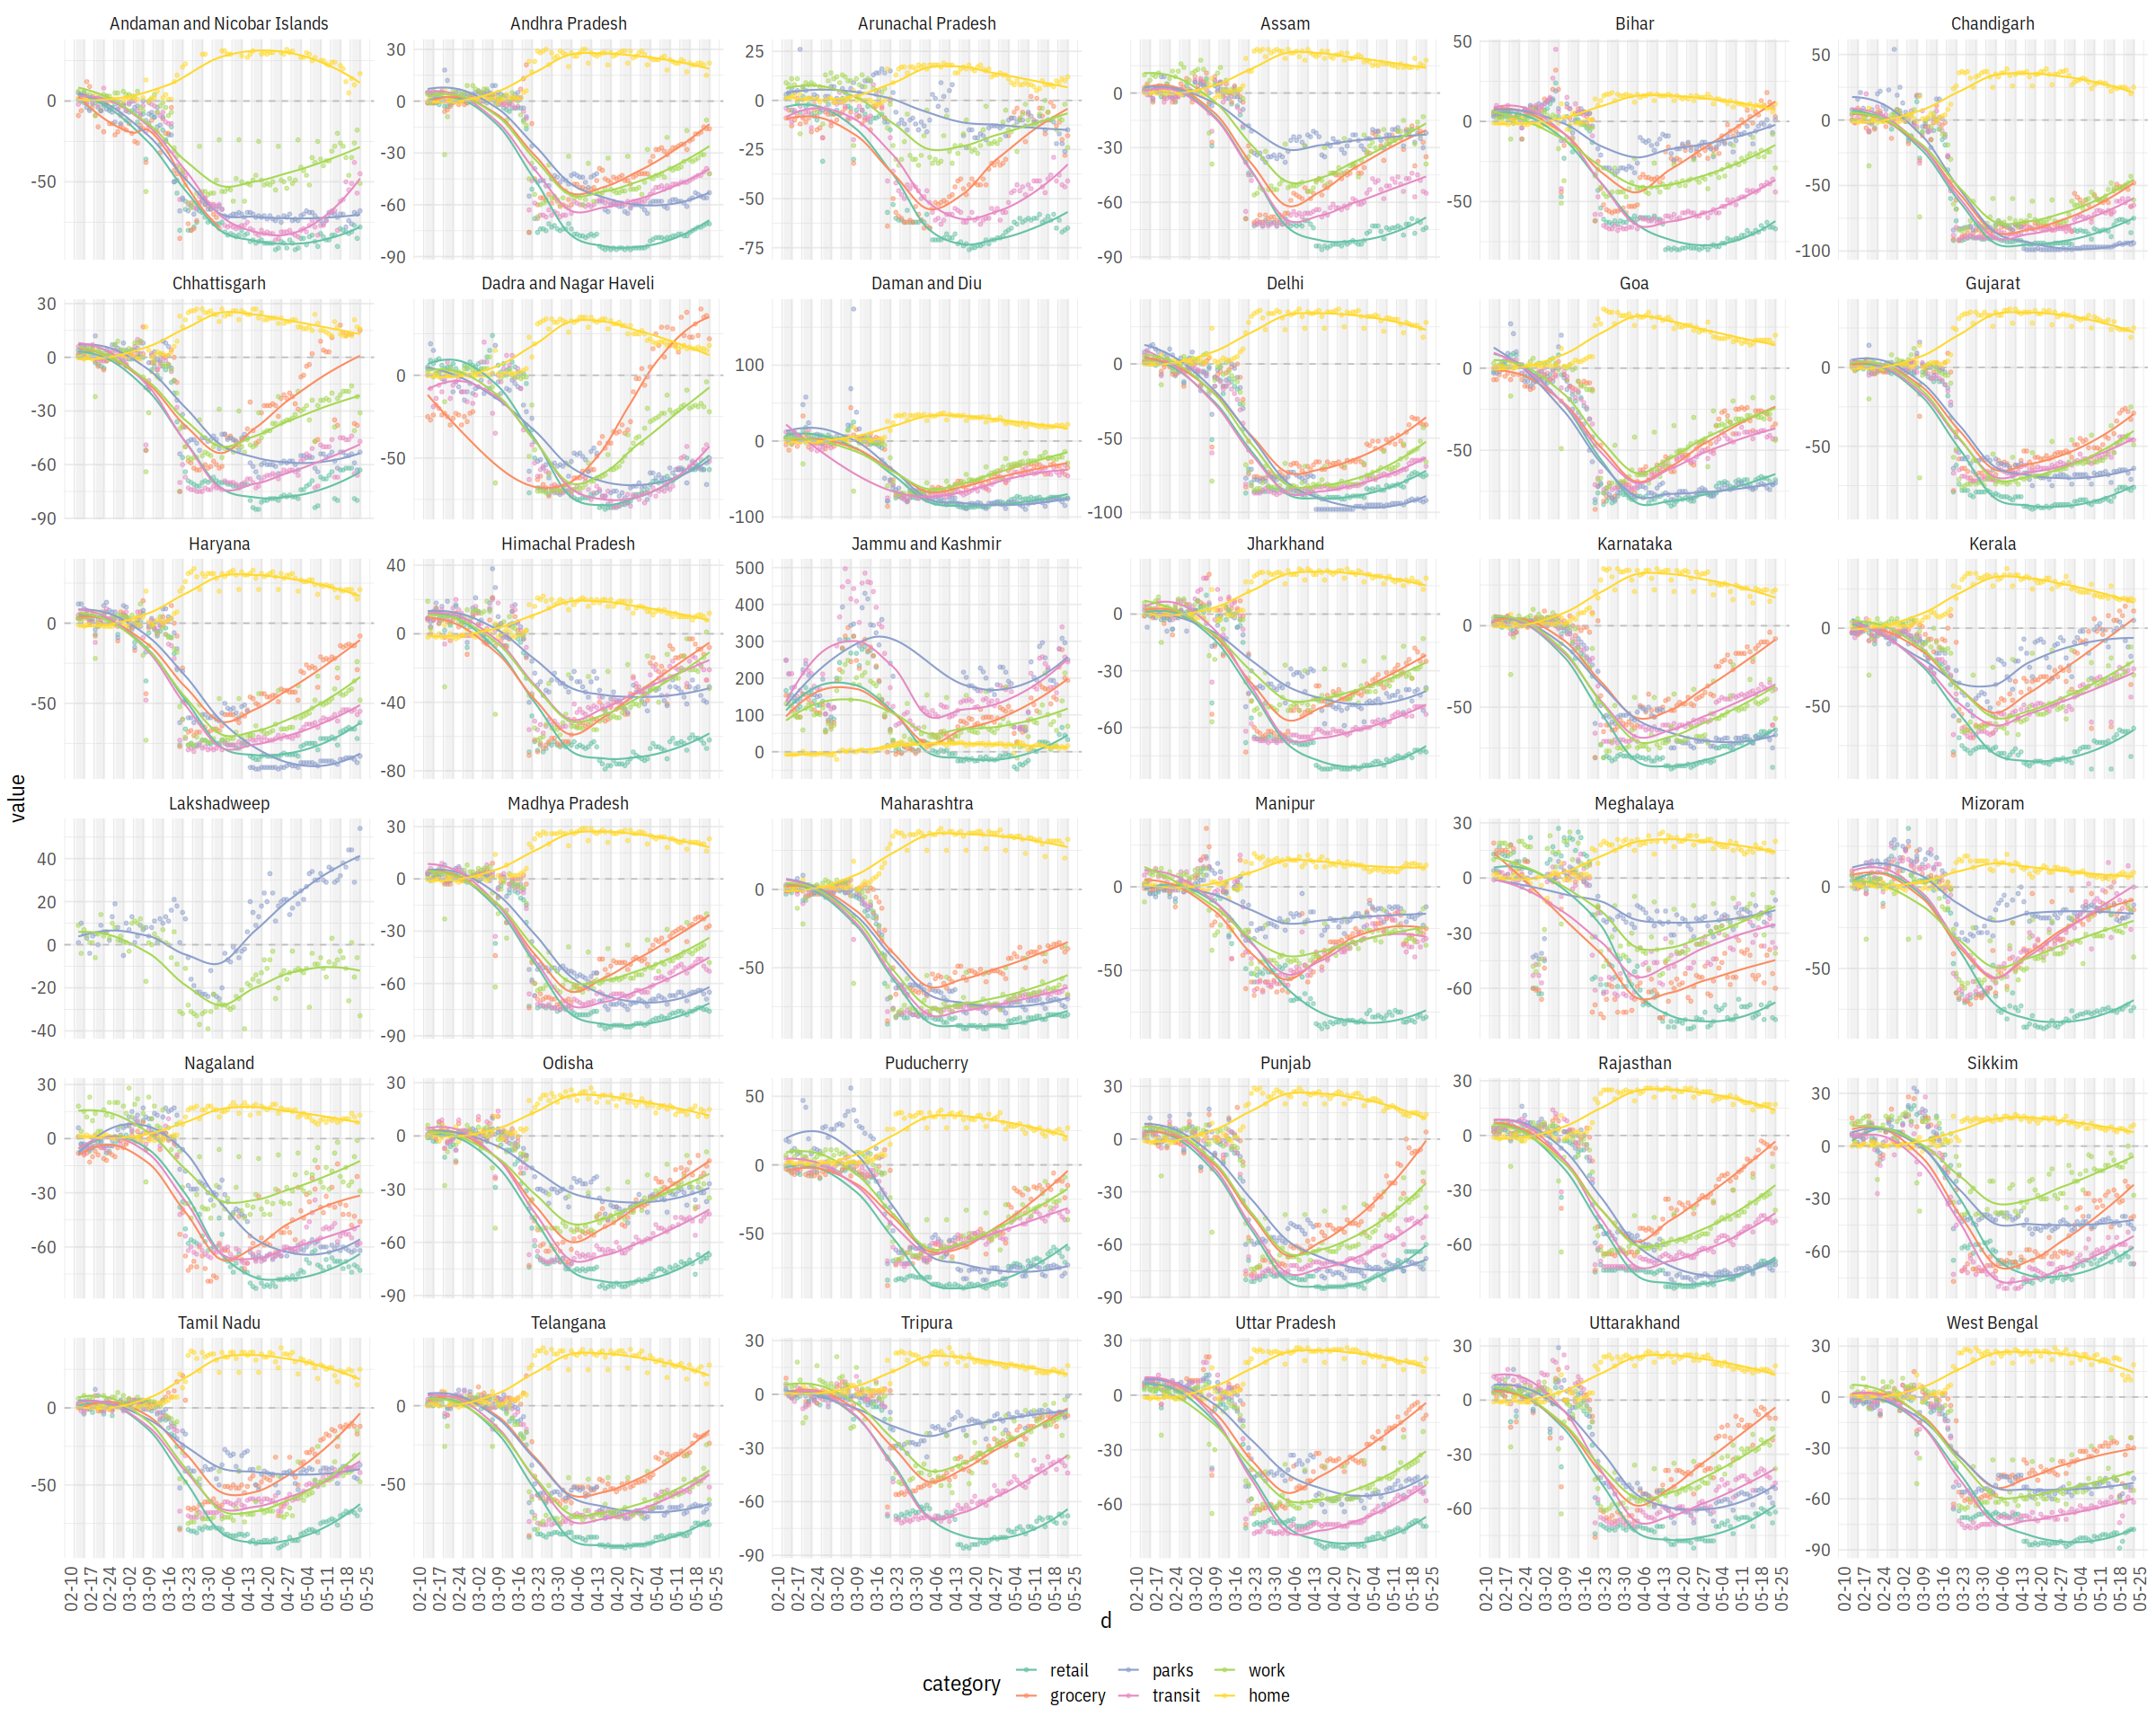

In [18]:
ind = mobility_df[country_region =="India"]
ind_l = melter(ind, c("sub_region_1", "d", "weekend"))
ind_l = ind_l[sub_region_1 != ""]
ind %>% head

(ind_disagg = subregion_faceted(ind_l, freescale = T))
ggsave("ind_mobility.jpg", ind_disagg, width = 30, height = 30)

Jammu and Kashmir up by 300%+ because the baseline period corresponds with a sever lockdown [for political reasons - abrogation of article 370 etc]. Baselines matter in DiD.

In [19]:
countries_w_subn = mobility_df[, .(sub = unique(sub_region_1)), by = country_region][sub != ""]
countries_w_subn[, unique(country_region)] %>% print

 [1] "United Arab Emirates" "Antigua and Barbuda"  "Angola"              
 [4] "Argentina"            "Austria"              "Australia"           
 [7] "Barbados"             "Belgium"              "Burkina Faso"        
[10] "Bulgaria"             "Benin"                "Bolivia"             
[13] "Brazil"               "The Bahamas"          "Belize"              
[16] "Canada"               "Switzerland"          "Côte d'Ivoire"       
[19] "Chile"                "Cameroon"             "Colombia"            
[22] "Cape Verde"           "Czechia"              "Germany"             
[25] "Denmark"              "Dominican Republic"   "Ecuador"             
[28] "Estonia"              "Egypt"                "Spain"               
[31] "Finland"              "France"               "Gabon"               
[34] "United Kingdom"       "Greece"               "Guatemala"           
[37] "Honduras"             "Croatia"              "Haiti"               
[40] "Hungary"              "Indonesia

sub_region_1   d          weekend category value
1 Kajiado County 2020-02-15  TRUE   retail    -2  
2 Kajiado County 2020-04-07 FALSE   retail   -29  
3 Kajiado County 2020-04-08 FALSE   retail   -31  
4 Kajiado County 2020-04-09 FALSE   retail   -29  
5 Kajiado County 2020-04-10 FALSE   retail   -33  
6 Kajiado County 2020-04-13 FALSE   retail   -34

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 9669 rows containing non-finite values (stat_smooth).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 18364”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 14.105”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 228.16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, de

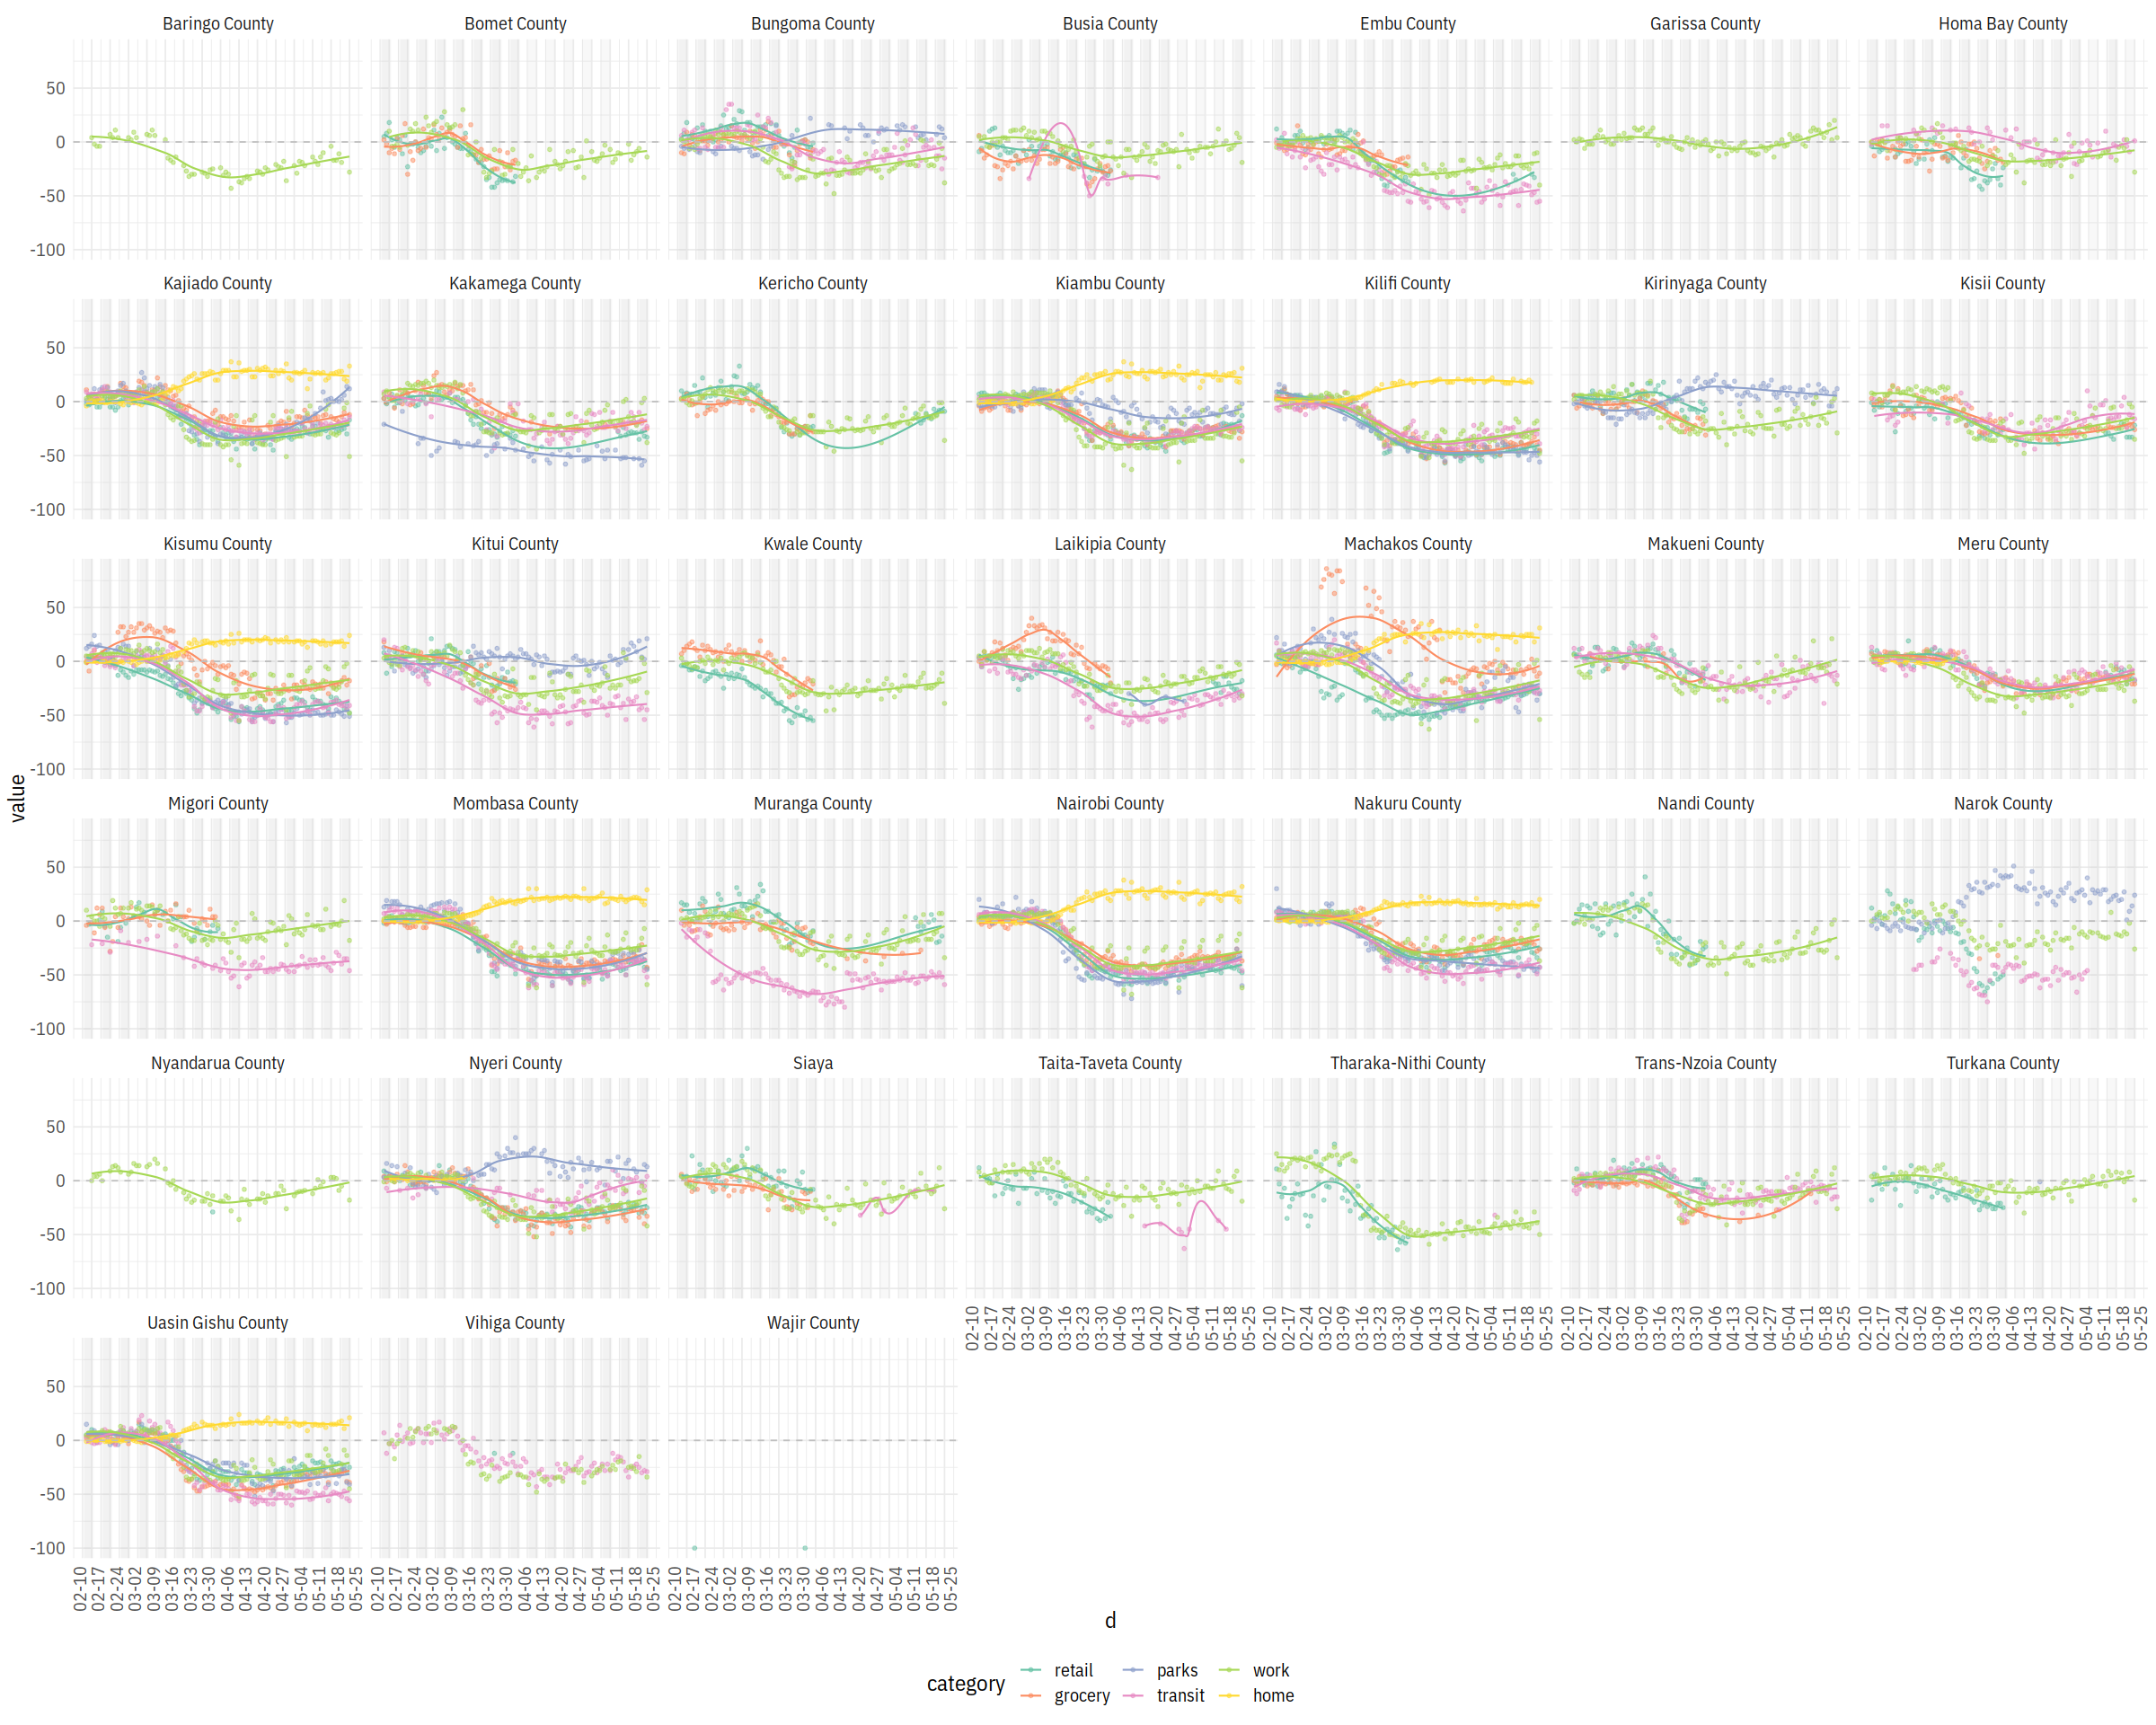

In [20]:
d = mobility_df[country_region =="Kenya"]
d_l= melter(d, c("sub_region_1", "d", "weekend")) %>% .[sub_region_1 != ""]
d_l %>% head

(ind_disagg = subregion_faceted(d_l))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 23 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 23 rows containing missing values (geom_point).”


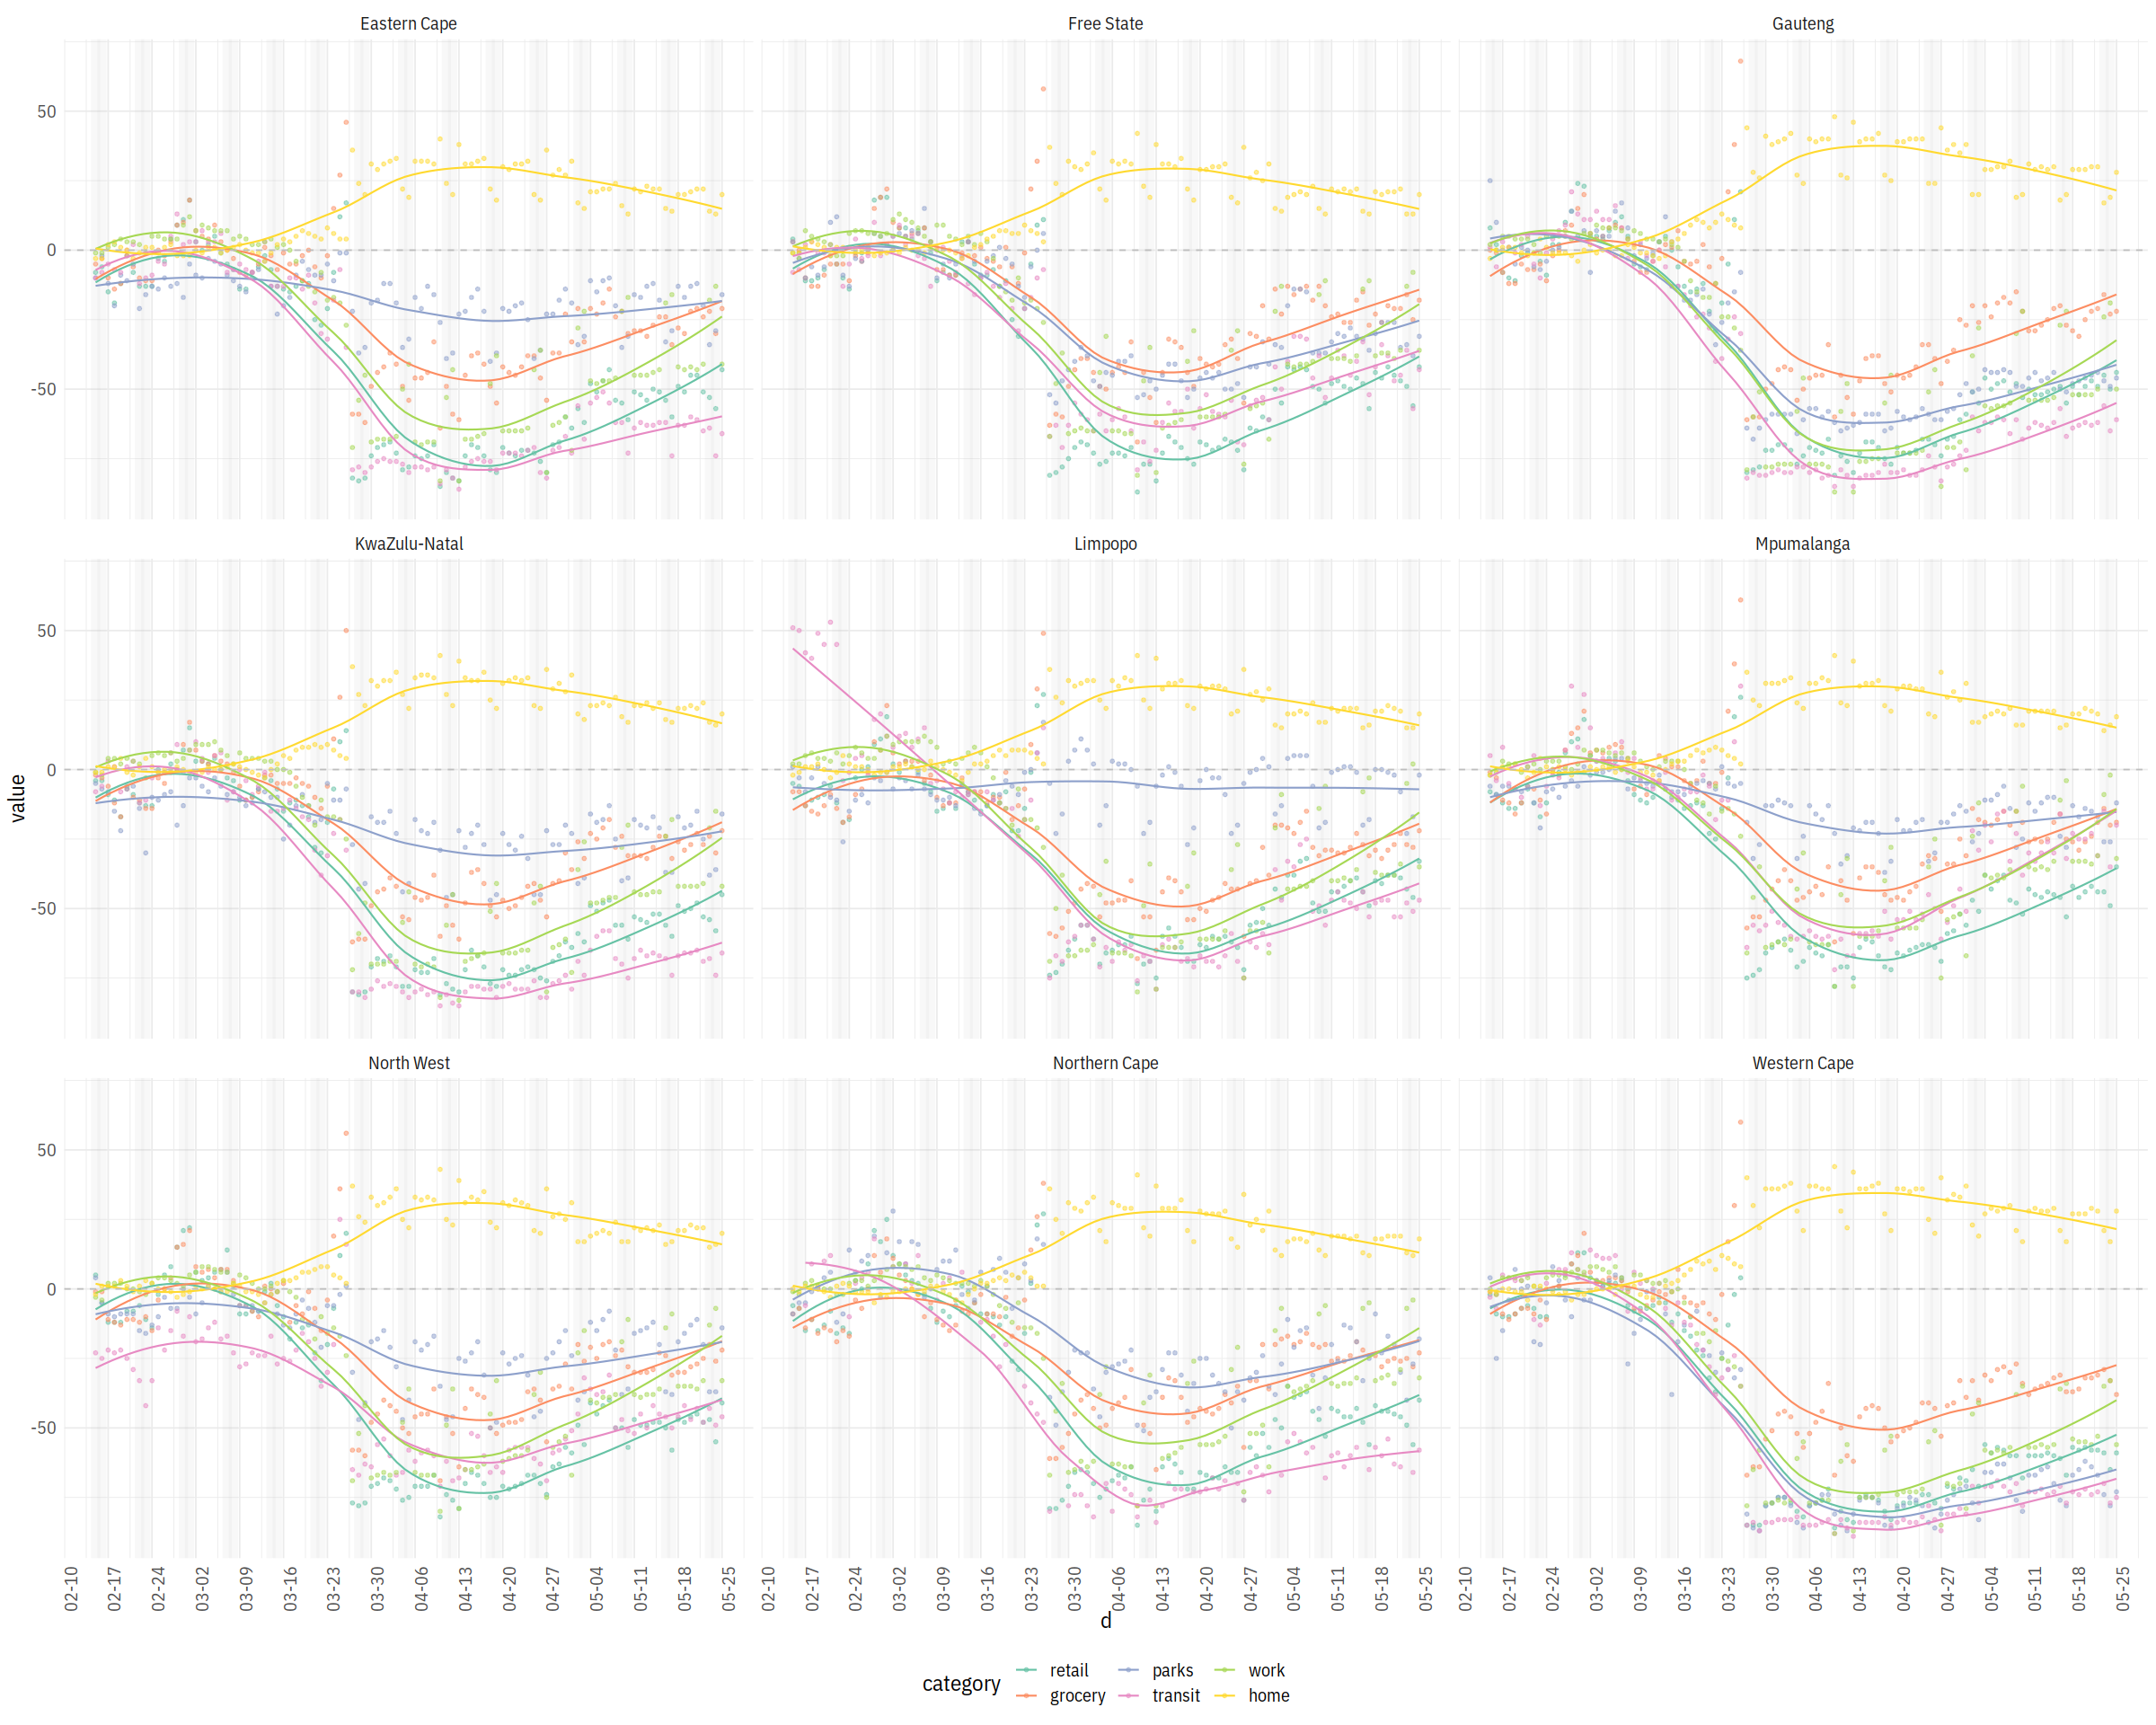

In [21]:
d = mobility_df[country_region =="South Africa"]
d_l= melter(d, c("sub_region_1", "d", "weekend")) %>% .[sub_region_1 != ""]
(ind_disagg = subregion_faceted(d_l))

# Govt Policy Tracker

In [32]:
options(repr.plot.width = 12, repr.plot.height=10)

In [23]:
projid <- Sys.getenv("GCE_DEFAULT_PROJECT_ID")
bq_auth(email = "lal.apoorva@gmail.com",
       path = "~/keys/sandbox.json")

In [24]:
bq_con <-  dbConnect(
    bigrquery::bigquery(),
    project = "bigquery-public-data",
    dataset = "covid19_govt_response",
    billing = projid
    )
bq_con
dbListTables(bq_con)

<BigQueryConnection>
  Dataset: bigquery-public-data.covid19_govt_response
  Billing: spatial-acumen-244921

[1] "oxford_policy_tracker"

In [25]:
mob <- tbl(bq_con, "oxford_policy_tracker")
mob %>% glimpse

Rows: ??
Columns: 52
Database: BigQueryConnection
$ country_name                            <chr> "Aruba", "Afghanistan", "Ango…
$ alpha_3_code                            <chr> "ABW", "AFG", "AGO", "AGO", "…
$ date                                    <date> 2020-05-23, 2020-05-22, 2020…
$ school_closing                          <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ school_closing_flag                     <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ school_closing_notes                    <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ workplace_closing                       <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ workplace_closing_flag                  <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ workplace_closing_notes                 <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ cancel_public_events                    <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ cancel_public_events_flag               <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ cancel_public_events_notes              <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ 

In [26]:
tic()
mob %>% collect() ->
    policies
toc()

6.797 sec elapsed


In [27]:
policies %<>% setDT

fwrite(policies, "data/ox_policy_tracker.csv")
dbDisconnect(bq_con)

## Viz

In [28]:
policies = fread("data/ox_policy_tracker.csv")
policies[, date := lubridate::ymd(date)]
policies %>% glimpse

Rows: 23,909
Columns: 52
$ country_name                            <chr> "Aruba", "Afghanistan", "Ango…
$ alpha_3_code                            <chr> "ABW", "AFG", "AGO", "AGO", "…
$ date                                    <date> 2020-05-23, 2020-05-22, 2020…
$ school_closing                          <dbl> NA, NA, NA, NA, NA, NA, NA, N…
$ school_closing_flag                     <int> NA, NA, NA, NA, NA, NA, NA, N…
$ school_closing_notes                    <chr> "", "", "", "", "", "", "", "…
$ workplace_closing                       <dbl> NA, NA, NA, NA, NA, NA, NA, N…
$ workplace_closing_flag                  <int> NA, NA, NA, NA, NA, NA, NA, N…
$ workplace_closing_notes                 <chr> "", "", "", "", "", "", "", "…
$ cancel_public_events                    <dbl> NA, NA, NA, NA, NA, NA, NA, N…
$ cancel_public_events_flag               <int> NA, NA, NA, NA, NA, NA, NA, N…
$ cancel_public_events_notes              <chr> "", "", "", "", "", "", "", "…
$ restrictions_on_gathering

In [29]:
policies[, .N, by = .(country_name, alpha_3_code)][order(country_name)]

country_name           alpha_3_code N  
1   Afghanistan            AFG          143
2   Albania                ALB          143
3   Algeria                DZA          143
4   Andorra                AND          143
5   Angola                 AGO          143
6   Argentina              ARG          143
7   Aruba                  ABW          144
8   Australia              AUS          143
9   Austria                AUT          144
10  Azerbaijan             AZE          144
11  Bahrain                BHR          143
12  Bangladesh             BGD          143
13  Barbados               BRB          143
14  Belarus                BLR          143
15  Belgium                BEL          143
16  Belize                 BLZ          143
17  Benin                  BEN          143
18  Bermuda                BMU          143
19  Bhutan                 BTN          144
20  Bolivia                BOL          144
21  Bosnia and Herzegovina BIH          143
22  Botswana               BWA          143
23  Brazil                 BRA          144
24  Brunei                 BRN          143
25  Bulgaria               BGR          143
26  Burkina Faso           BFA          143
27  Burundi                BDI          143
28  Cameroon               CMR          143
29  Canada                 CAN          143
30  Cape Verde             CPV          143
⋮   ⋮                      ⋮            ⋮  
138 Somalia                SOM          143
139 South Africa           ZAF          143
140 South Korea            KOR          144
141 South Sudan            SSD          143
142 Spain                  ESP          144
143 Sri Lanka              LKA          143
144 Sudan                  SDN          143
145 Suriname               SUR          143
146 Sweden                 SWE          144
147 Switzerland            CHE          143
148 Syria                  SYR          143
149 Taiwan                 TWN          143
150 Tanzania               TZA          143
151 Thailand               THA          143
152 Trinidad and Tobago    TTO          143
153 Tunisia                TUN          143
154 Turkey                 TUR          143
155 Turkmenistan           TKM          140
156 Uganda                 UGA          143
157 Ukraine                UKR          143
158 United Arab Emirates   ARE          144
159 United Kingdom         GBR          143
160 United States          USA          143
161 Uruguay                URY          143
162 Uzbekistan             UZB          143
163 Venezuela              VEN          143
164 Vietnam                VNM          143
165 Yemen                  YEM          143
166 Zambia                 ZMB          143
167 Zimbabwe               ZWE          143

In [30]:
sa = policies[alpha_3_code %in% c("IND", "NPL", "PAK", "BGD", "LKA", "AFG")]

tsplot = function(df){
    p = ggplot(df, aes(x = date, y = stringency_index, group = alpha_3_code, colour = alpha_3_code)) +
    geom_point() + geom_line() + scale_colour_brewer(palette = "Set2")
    return(p)
}

Warning message:
“Removed 2 rows containing missing values (geom_point).”


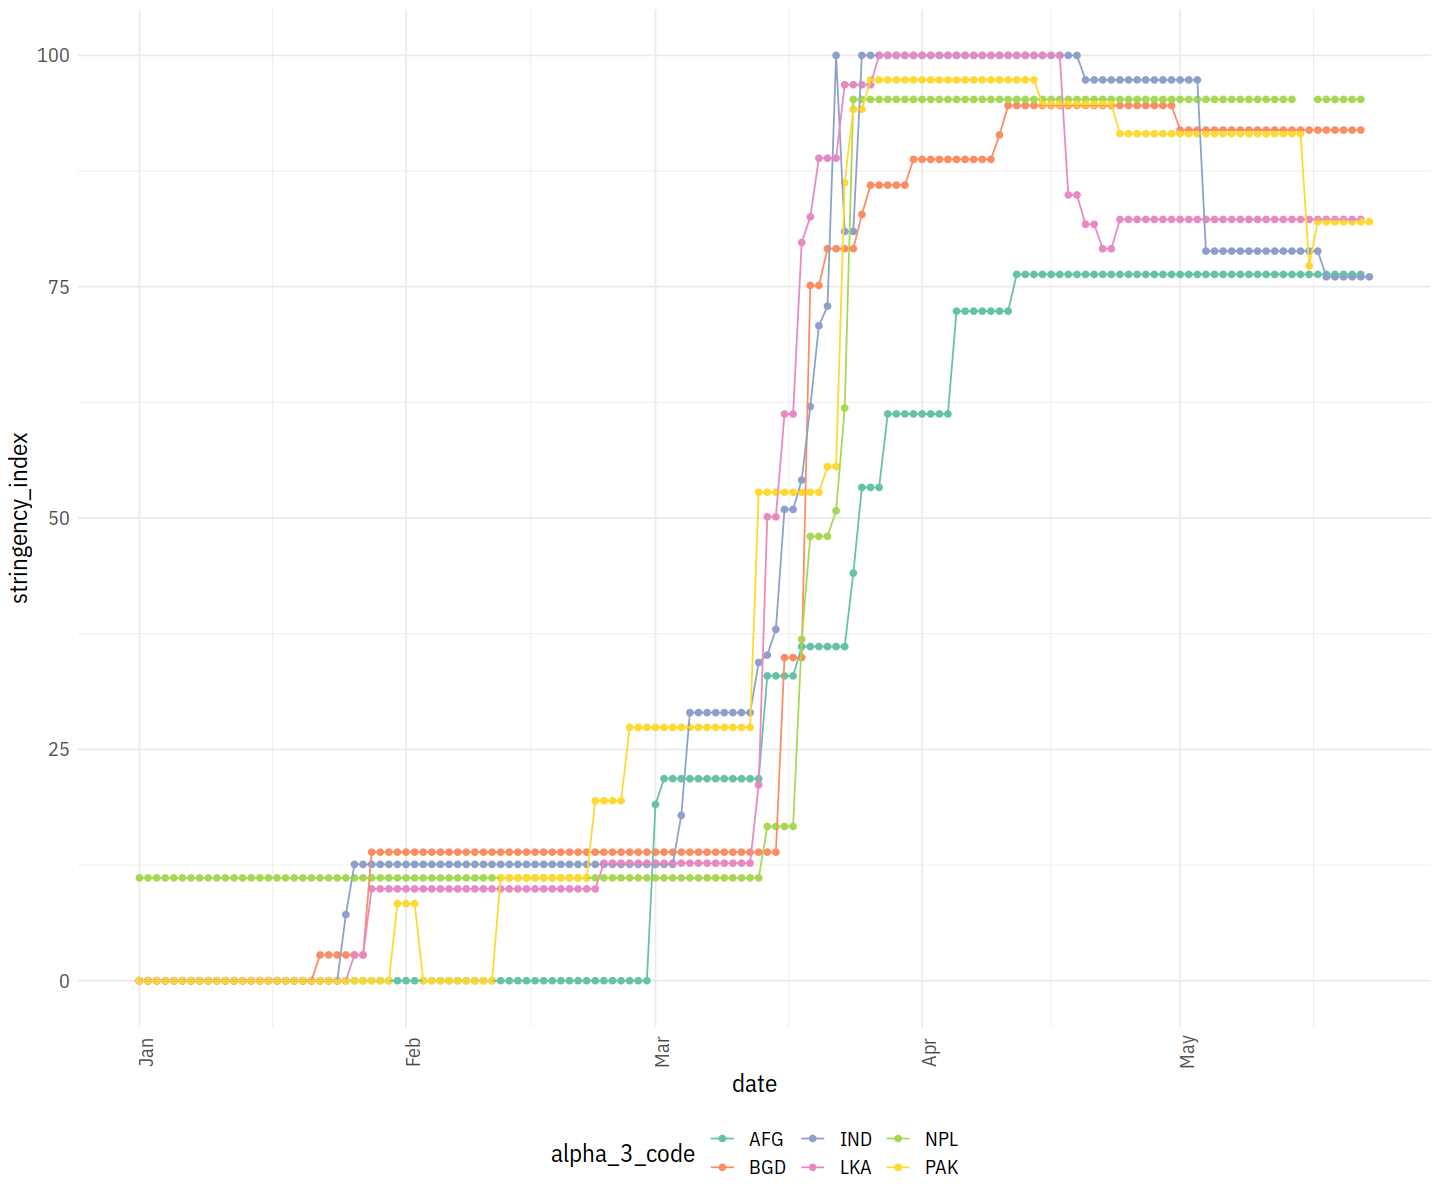

In [33]:
tsplot(sa)